# Data Science
- Student: Dmytro Geleshko
- Group: IP-91
- Var: 6

# Imports

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

# Config

In [13]:
# var 6
np.random.seed(6)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

# Load data

In [14]:
df = pd.read_csv("mod_data.csv", index_col="date", parse_dates=True, dtype=np.float32)
df.drop(columns=["close", "volume", "log_close", "log_fit"], inplace=True)
df

,volume_norm,log_diff,day_sin,day_cos,year_sin,year_cos
date,,,,,,
2010-07-18,-0.674,-0.878,-0.000,1.000,-0.266,-0.964
2010-07-19,-0.672,-0.884,-0.000,1.000,-0.283,-0.959
2010-07-20,-0.673,-0.890,-0.000,1.000,-0.299,-0.954
2010-07-21,-0.672,-0.896,0.000,1.000,-0.316,-0.949
2010-07-22,-0.666,-0.902,-0.000,1.000,-0.332,-0.943
...,...,...,...,...,...,...
2021-11-21,-0.523,1.564,-0.000,1.000,-0.643,0.766
2021-11-22,-0.392,1.523,-0.000,1.000,-0.630,0.777
2021-11-23,-0.406,1.545,-0.000,1.000,-0.616,0.787


In [15]:
df.index.dtype, df.dtypes

(dtype('<M8[ns]'),
 volume_norm    float32
 log_diff       float32
 day_sin        float32
 day_cos        float32
 year_sin       float32
 year_cos       float32
 dtype: object)

In [16]:
log_fit_coef = np.array([[ 9.41599146e+00], [-5.06317303e-08]], dtype=np.float64)

## Train/Test

In [17]:
# input: past 3 weeks
Tx = 21
# output: next 1 week
Ty = 7
# number of features
features = ["volume_norm", "log_diff", "day_sin", "day_cos", "year_sin", "year_cos"]
n = len(features)
# size of train/test data
m = df.shape[0] - (Tx + Ty)

In [18]:
X = np.zeros((m, Tx, n))
y = np.zeros((m, Ty))

for i in range(y.shape[0]):
    X[i, :, :] = df[features].iloc[i:i+Tx].values
    y[i, :] = df["log_diff"].iloc[i+Tx: i+Tx+Ty].values

X = X.astype(np.float32)
y = y.astype(np.float32)

X.shape, X.dtype, y.shape, y.dtype

((4121, 21, 6), dtype('float32'), (4121, 7), dtype('float32'))

In [19]:
batch_size = 32
train_size = int(X.shape[0] * 0.9)

In [20]:
X_train = X[:train_size, :, :]
y_train = y[:train_size, :]
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)

X_test = X[train_size:, :, :]
y_test = y[train_size:, :]
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print(train_dataset)

print("X_test", X_test.shape)
print("y_test", y_test.shape)
print(test_dataset)

X_train (3708, 21, 6)
y_train (3708, 7)
<BatchDataset shapes: ((None, 21, 6), (None, 7)), types: (tf.float32, tf.float32)>
X_test (413, 21, 6)
y_test (413, 7)
<BatchDataset shapes: ((None, 21, 6), (None, 7)), types: (tf.float32, tf.float32)>


# Model

In [21]:
def create_model(Tx, features, Ty, learning_rate=0.01, decay=0.01):
    X_in = layers.Input(shape=(Tx, features))
    X = layers.LSTM(42, activation="relu", return_sequences=False)(X_in)
    X_out = layers.Dense(7, activation="relu")(X)

    model = tf.keras.Model(inputs=X_in, outputs=X_out)

    opt = tf.optimizers.Adam(learning_rate=learning_rate, decay=decay)
    model.compile(optimizer=opt, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanSquaredError()])

    return model

In [36]:
model = create_model(Tx, n, Ty, learning_rate=0.02, decay=0.02)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 21, 6)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 42)                8232      
                                                                 
 dense_3 (Dense)             (None, 7)                 301       
                                                                 
Total params: 8,533
Trainable params: 8,533
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(train_dataset, epochs=50)

Epoch 1/100
116/116 [==============================] - 1s 6ms/step - loss: 0.8704 - mean_squared_error: 0.8704
Epoch 2/100
116/116 [==============================] - 1s 7ms/step - loss: 1.5163 - mean_squared_error: 1.5163
Epoch 3/100
116/116 [==============================] - 1s 6ms/step - loss: 0.6808 - mean_squared_error: 0.6808
Epoch 4/100
116/116 [==============================] - 1s 6ms/step - loss: 0.6546 - mean_squared_error: 0.6546
Epoch 5/100
116/116 [==============================] - 1s 6ms/step - loss: 0.7647 - mean_squared_error: 0.7647
Epoch 6/100
116/116 [==============================] - 1s 5ms/step - loss: 0.6008 - mean_squared_error: 0.6008
Epoch 7/100
116/116 [==============================] - 1s 6ms/step - loss: 0.5278 - mean_squared_error: 0.5278
Epoch 8/100
116/116 [==============================] - 1s 5ms/step - loss: 0.5366 - mean_squared_error: 0.5366
Epoch 9/100
116/116 [==============================] - 1s 6ms/step - loss: 0.5022 - mean_squared_error: 0.5022
E

In [34]:
model.evaluate(test_dataset)

13/13 [==============================] - 0s 4ms/step - loss: 0.2228 - mean_squared_error: 0.2228


[0.2227736860513687, 0.2227736860513687]

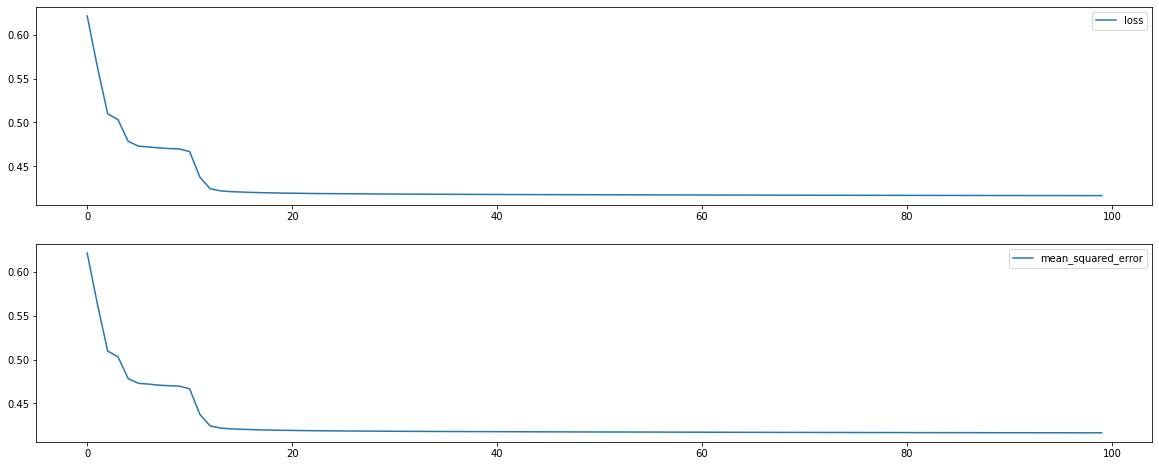

In [35]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(history.history["loss"], label="loss")
axes[0].legend()
axes[1].plot(history.history["mean_squared_error"], label="mean_squared_error")
axes[1].legend()
plt.show()